In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd
import numpy as np
import os
import pathlib
import sys
import git

In [2]:
code_paths = {}
code_paths["repo_name"] = "p5-stress-classifier"

code_paths["repo_path"] = os.getcwd()
base_dir = os.path.basename(code_paths["repo_path"])
while base_dir != code_paths["repo_name"]:
    code_paths["repo_path"] = os.path.dirname(os.path.abspath(code_paths["repo_path"]))
    base_dir = os.path.basename(code_paths["repo_path"])

package_dir = pathlib.Path(code_paths["repo_path"], "src")
sys.path.append(str(package_dir))
from stresspred import (
    peak_time_to_rri,
    P5_StressDataLoader,
    timestamp_to_samp,
    resample_nonuniform,
    code_paths,
    timestamps_to_audacity_txt,
    find_files_with_string,
    hb_extract,
    frame_timestamps,
    find_local_hb_peaks,
    get_camel_case,
    write_dict_to_json,
    find_correct_file,
    load_event_labels,
    samp_to_timestamp
)

C:\Users\dbenesch\.conda\envs\stress-requirements\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
for path in code_paths["neurokit2_paths"]:
    sys.path.append(str(path))
    
from neurokit2 import signal_interpolate, find_outliers
import neurokit2 as nk

In [4]:
from json_tricks import load

In [5]:
ann_info_path = str(pathlib.Path(r"Z:\Shared\Documents\RD\RD2\_AudioRD\datasets\Biosignals\CritiasStress\data_derivatives\Stage_ltallon\annotation_info.csv"))
ann_info_df = pd.read_csv(ann_info_path)

In [7]:
all_sub_part_ids = P5_StressDataLoader().get_all_sub_part_ids()
version_id = 117
data_format = "DB8k"
# sig_name = "zephyr_ecg"
sig_name = "ieml"
# hb_extract_method = "critias_bp"

# frame_len = 30
# frame_len = 180
# frame_len = 180
ecg_process_methods = [
    "neurokit",
    "pantompkins1985",
    "hamilton2002",
    "christov2004",
    "engzeemod2012",
    "elgendi2010",
    "kalidas2017",
]
hb_extract_method = "pc"
hb_extract_method = "nk_ppg_elgendi"
hb_extract_method = "temp"
repo = git.Repo(search_parent_directories=True)
git_hexsha = repo.head.object.hexsha


frame_len = 300

version_id += 1
sub_id = "P02"
part_id = 1
loader = P5_StressDataLoader(sub_id=sub_id, part_id=part_id)
sig_info = loader.get_sig(data_format=data_format, sig_name=sig_name)

if "nk" in hb_extract_method:
    auto_method_acronym = "NK"
else:
    auto_method_acronym = hb_extract_method.upper()
name_peaks_dict = {"zephyr_ecg": "R_Peak", "ti_ppg": "SP", "ieml": "S1_Peak"}
label = name_peaks_dict[sig_info["name"]]


txt_json_base_name = (
    "P5_Stress-"
    + loader.sub_label
    + "_"
    + str(loader.part_id)
    + "-"
    + sig_info["name"]
    + "-Ann-Auto-"
    + auto_method_acronym
    + "-"
    + name_peaks_dict[sig_info["name"]]
    + "_v"
    + str(version_id)
)
txt_file_name = txt_json_base_name + ".txt"
json_file_name = txt_json_base_name + ".json"
txt_path = str(
    pathlib.Path(
        loader.get_paths(data_format="hb_annotations")["sub_data_dir"],
        "v" + str(version_id),
        txt_file_name,
    )
)

json_path = str(
    pathlib.Path(
        loader.get_paths(data_format="hb_annotations")["sub_data_dir"],
        "v" + str(version_id),
        json_file_name,
    )
)

debug_out_path = str(
    pathlib.Path(
        loader.get_paths(data_format="hb_annotations")["sub_data_dir"],
        "v" + str(version_id),
        txt_json_base_name + "_debug_out",
    )
)

hb_extract_algo_kwargs = {
    "max_bpm": 200,
    "min_bpm": 40,
    "denoiser_type": "null",
    "thr_corr_height": -3,
    "min_n_confident_peaks": 20,
    "max_time_after_last_peak": 5,
    "clean_method": "own_filt",
    "highcut": 25,
    "relative_peak_height_for_temp_min": -2,
    "relative_peak_height_for_temp_max": 2,
    "temp_time_before_peak": 0.3,
    "temp_time_after_peak": 0.3,
    "fix_corr_peaks_by_height": False,
    "fix_interpl_peaks_by_height": False,
    "relative_rri_min": -2.5,
    "relative_rri_max": 2.5,
    "fixpeaks_by_height_time_boundaries": {
        "before_peak_clean": 0.1,
        "after_peak_clean": 0.1,
        "before_peak_raw": 0.005,
        "after_peak_raw": 0.005,
    },
    "corr_peak_extraction_method": "nk_ecg_process",
    "k_nearest_intervals": 8,
    "n_nan_estimation_method": "round",
    "interpolate_args": {"method": "spline", "order": 2},
    "output_format": "debug_out",
    "debug_out_path": debug_out_path,
}


hb_extract_params = hb_extract_algo_kwargs.copy()
hb_extract_params["detector_type"] = hb_extract_method
hb_extract_params["frame_len"] = frame_len
hb_extract_params["validity"] = True
hb_extract_params["version"] = version_id
hb_extract_params["git_hexsha"] = git_hexsha

write_dict_to_json(hb_extract_params, json_path=json_path)


if not pathlib.Path(txt_path).is_file():
    sig_info["peak_time"] = frame_timestamps(
        func=hb_extract,
        sig=sig_info["sig"],
        sig_time=sig_info["time"],
        frame_len=frame_len,
        sig_name=sig_info["name"],
        method=hb_extract_method,
        hb_extract_algo_kwargs=hb_extract_algo_kwargs,
        save_file=True,
        txt_path=txt_path,
        label=label,
    )

In [8]:
json_path

'Z:Shared\\Documents\\RD\\RD2\\_AudioRD\\datasets\\Biosignals\\CritiasStress\\data_derivatives\\DB8k\\P02\\v118\\P5_Stress-P02_1-ieml-Ann-Auto-TEMP-S1_Peak_v118.json'

In [585]:
sub_label = "P02"
part_id = 1
loader = P5_StressDataLoader(sub_id=sub_label, part_id=part_id)

In [586]:
gt_d = ann_info_df[
        (ann_info_df["sig_name"] == "zephyr_ecg")
        & (ann_info_df["sub_label"] == sub_label)
        & (ann_info_df["part_id"] == part_id)
        & (ann_info_df["best_version"] == 1)
        & (ann_info_df["entire_file_annotated"] == 1)
    ].to_dict("records")[0]

In [587]:
gt_p = pathlib.Path(
    pathlib.Path(ann_info_path).parent, gt_d["parent_path"], gt_d["file_name"]
)
gt_p = find_correct_file(gt_p)
gt_peak_time = load_event_labels(file_path=str(gt_p))["points"]["events"]["onset"]
gt_rri, gt_rri_time = peak_time_to_rri(
    gt_peak_time, min_rri=60000 / 200, max_rri=60000 / 40
)

In [588]:
start_time = 300
end_time = start_time + frame_len

In [589]:
sig_name = "ieml"
sig_info = loader.get_sig(sig_name=sig_name, start_time=start_time, end_time=end_time)
sig = sig_info["sig"]
sig_time = sig_info["time"]
sampling_rate = sig_info["sampling_rate"]

In [590]:
peaks, debug_out = hb_extract(
    sig=sig,
    sampling_rate=sampling_rate,
    sig_time=sig_time,
    sig_name=sig_name,
    method=hb_extract_method,
    subtract_mean=True,
    hb_extract_algo_kwargs=hb_extract_algo_kwargs,
)

In [591]:
#loader = P5_StressDataLoader()
#p = str(list(loader.get_paths(data_format="hb_annotations")["formatted_data_dir"].rglob("*debug_out*.json"))[0])

In [592]:
#d = load(p)
d = debug_out.copy()

In [593]:
d.keys()

dict_keys(['clean_sig_r', 'clean_sig_time_r', 'new_sampling_rate', 'height_min', 'height_max', 'peak_time_for_temp', 'peak_time_for_temp_confident', 'med_template', 'corrs', 'corr_times', 'peak_time_from_corr', 'peak_time_from_corr_confident', 'new_peak_time', 'final_peak_time'])

In [594]:
peak_time = d["final_peak_time"]
rri, rri_time = peak_time_to_rri(
    peak_time, min_rri=60000 / 200, max_rri=60000 / 40
)

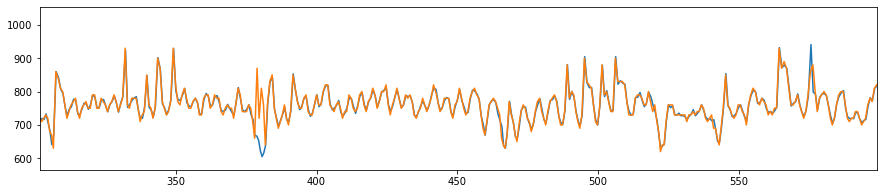

In [595]:
plt.figure(figsize=(15,3))
plt.plot(gt_rri_time, gt_rri)
plt.plot(rri_time, rri)
plt.xlim([np.min(rri_time), np.max(rri_time)])
plt.show()

In [596]:
xlim_td = [375, 390]

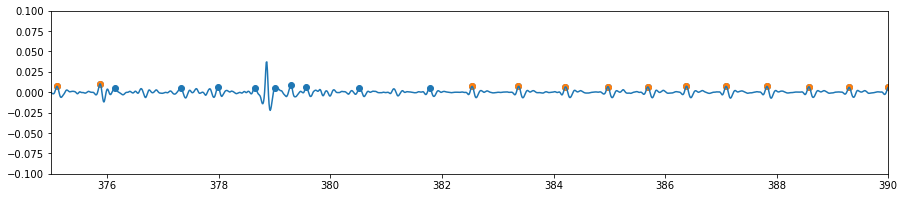

In [597]:
plt.figure(figsize=(15,3))
plt.plot(d["clean_sig_time_r"], d["clean_sig_r"])
plt.scatter(d["peak_time_for_temp"], d["clean_sig_r"][timestamp_to_samp(d["peak_time_for_temp"], sig_time=d["clean_sig_time_r"])])
plt.scatter(d["peak_time_for_temp_confident"], d["clean_sig_r"][timestamp_to_samp(d["peak_time_for_temp_confident"], sig_time=d["clean_sig_time_r"])])
plt.ylim([-0.1, 0.1])
plt.xlim(xlim_td)
plt.show()

In [598]:
rri, rri_time = peak_time_to_rri(
    peak_time, min_rri=60000 / 200, max_rri=60000 / 40
)

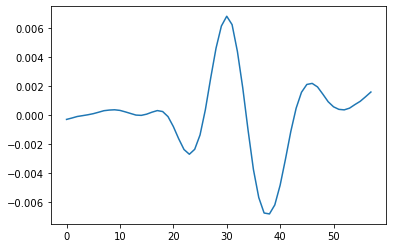

In [599]:
plt.plot(d["med_template"])

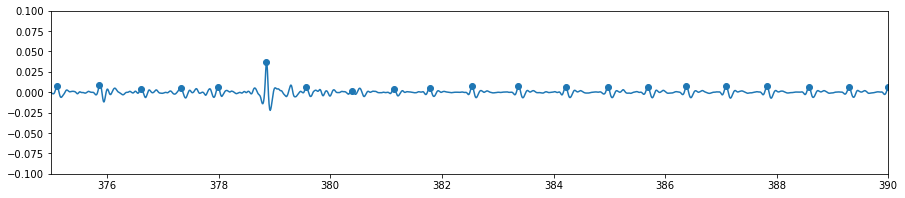

In [600]:
plt.figure(figsize=(15,3))
plt.plot(d["clean_sig_time_r"], d["clean_sig_r"])
plt.scatter(d["final_peak_time"], d["clean_sig_r"][timestamp_to_samp(d["final_peak_time"], sig_time=d["clean_sig_time_r"])])

plt.ylim([-0.1, 0.1])
plt.xlim(xlim_td)
plt.show()

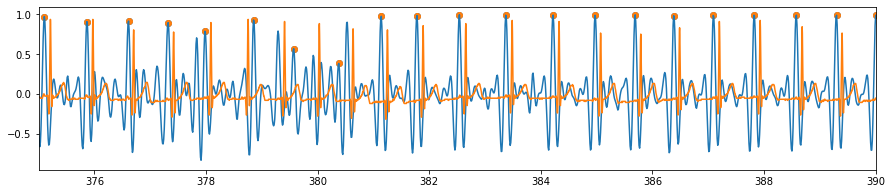

In [601]:
plt.figure(figsize=(15,3))
plt.plot(d["corr_times"], d["corrs"])
plt.scatter(d["peak_time_from_corr"], d["corrs"][timestamp_to_samp(d["peak_time_from_corr"], sig_time=d["corr_times"])])
plt.scatter(d["peak_time_from_corr_confident"], d["corrs"][timestamp_to_samp(d["peak_time_from_corr_confident"], sig_time=d["corr_times"])])
plt.plot(gt_sig_info["time"], gt_sig_info["sig"]/np.max(gt_sig_info["sig"]))

plt.xlim(xlim_td)
plt.show()

In [583]:
import scipy

In [556]:
signal = d["corrs"]
sampling_rate = d["new_sampling_rate"]
#def _ecg_findpeaks_kalidas(signal, sampling_rate=1000, **kwargs):
"""From https://github.com/berndporr/py-ecg-detectors/
- Vignesh Kalidas and Lakshman Tamil (2017). Real-time QRS detector using Stationary Wavelet Transform
  for Automated ECG Analysis. In: 2017 IEEE 17th International Conference on Bioinformatics and
  Bioengineering (BIBE). Uses the Pan and Tompkins thresolding.
"""
# Try loading pywt
try:
    import pywt
except ImportError as import_error:
    raise ImportError(
        "NeuroKit error: ecg_findpeaks(): the 'PyWavelets' module is required for"
        " this method to run. Please install it first (`pip install PyWavelets`)."
    ) from import_error

signal_length = len(signal)

swt_level = 3
padding = -1
for i in range(1000):
    if (len(signal) + i) % 2 ** swt_level == 0:
        padding = i
        break

if padding > 0:
    signal = np.pad(signal, (0, padding), "edge")
elif padding == -1:
    print("Padding greater than 1000 required\n")

swt_ecg = pywt.swt(signal, "db3", level=swt_level)
swt_ecg = np.array(swt_ecg)
swt_ecg = swt_ecg[0, 1, :]

#swt_ecg_clip = clip_signal(swt_ecg.copy(), method="prc", fs = ieml_fs, thr_down=True)
swt_ecg_clip = swt_ecg.copy()
squared = swt_ecg_clip * swt_ecg_clip

f1 = 0.01 / (0.5 * sampling_rate)
f2 = 10 / (0.5 * sampling_rate)

sos = scipy.signal.butter(3, [f1, f2], btype="bandpass", output="sos")
filtered_squared = scipy.signal.sosfilt(sos, squared)

# Drop padding to avoid detecting peaks inside it (#456)
filtered_squared = filtered_squared[:signal_length]
filtered_squared_clip = filtered_squared.copy()
#filtered_squared_clip = clip_signal(filtered_squared.copy(), method="prc", fs = ieml_fs, thr_down=True)
#filt_peaks = _ecg_findpeaks_peakdetect(filtered_squared_clip, sampling_rate)
filt_peaks, _ = scipy.signal.find_peaks(filtered_squared_clip, 
                                        distance=1/(200/60) * sampling_rate, 
                                        prominence=0.5*np.max(filtered_squared_clip))
filt_peaks = np.array(filt_peaks, dtype="int")

In [557]:
gt_sig_name = "zephyr_ecg"
gt_sig_info = loader.get_sig(sig_name=gt_sig_name, start_time=start_time, end_time=end_time)

C:\Users\dbenesch\eers\git\p5-stress-classifier\src\stresspred\preprocessing.py:429: UserWarning: Warning: the difference between timepoints is not uniform
  warn("Warning: the difference between timepoints is not uniform")


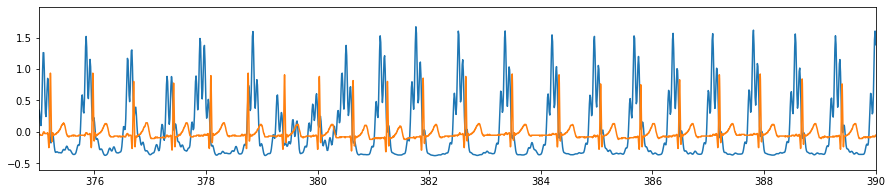

In [603]:
plt.figure(figsize=(15,3))
#plt.plot(d["corr_times"], swt_ecg)
plt.plot(d["corr_times"], filtered_squared)
plt.scatter(filt_peaks/sampling_rate + np.min(d["corr_times"]), filtered_squared[filt_peaks])
#plt.scatter(d["peak_time_from_corr_confident"], d["corrs"][timestamp_to_samp(d["peak_time_from_corr_confident"], sig_time=d["corr_times"])])
plt.plot(gt_sig_info["time"], gt_sig_info["sig"]/np.max(gt_sig_info["sig"]))

plt.xlim(xlim_td)
plt.show()

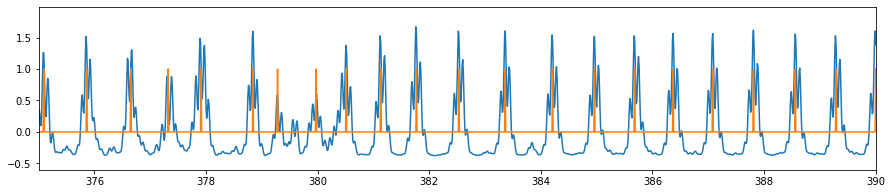

In [559]:
plt.figure(figsize=(15,3))

plt.plot(d["corr_times"], nk.ppg_process(filtered_squared, sampling_rate=sampling_rate)[0]["PPG_Raw"].values)
plt.plot(d["corr_times"], nk.ppg_process(filtered_squared, sampling_rate=sampling_rate)[0]["PPG_Peaks"].values)
plt.xlim(xlim_td)
plt.show()

In [560]:
ppg_process_times = samp_to_timestamp(nk.ppg_process(filtered_squared, sampling_rate=sampling_rate)[1]["PPG_Peaks"], sig_time=d["corr_times"])

In [561]:
rri, rri_time = peak_time_to_rri(
    ppg_process_times, min_rri=60000 / 200, max_rri=60000 / 40
)

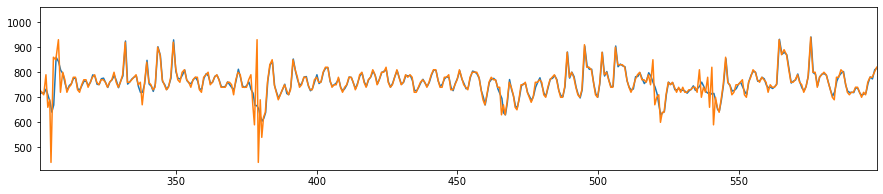

In [562]:
plt.figure(figsize=(15,3))
plt.plot(gt_rri_time, gt_rri)
plt.plot(rri_time, rri)
plt.xlim([np.min(rri_time), np.max(rri_time)])
plt.show()

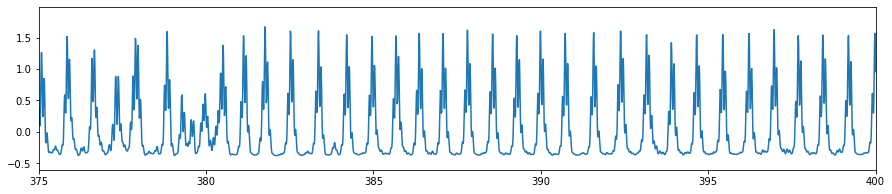

In [480]:
plt.figure(figsize=(15,3))
plt.plot(d["corr_times"], filtered_squared)
#plt.scatter(d["peak_time_from_corr"], d["corrs"][timestamp_to_samp(d["peak_time_from_corr"], sig_time=d["corr_times"])])
#plt.scatter(d["peak_time_from_corr_confident"], d["corrs"][timestamp_to_samp(d["peak_time_from_corr_confident"], sig_time=d["corr_times"])])

plt.xlim(xlim_td)
plt.show()

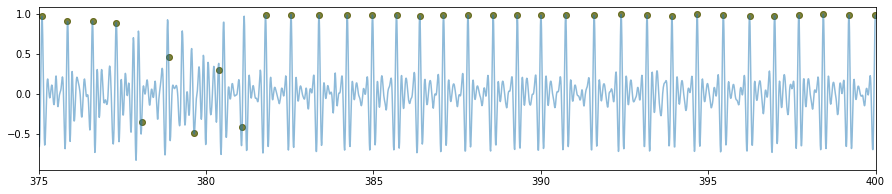

In [481]:
plt.figure(figsize=(15,3))
plt.plot(d["corr_times"], d["corrs"], alpha=0.5)
plt.scatter(d["peak_time_from_corr"], d["corrs"][timestamp_to_samp(d["peak_time_from_corr"], sig_time=d["corr_times"])], color="red", alpha=0.5)
plt.scatter(d["peak_time_from_corr_confident"], d["corrs"][timestamp_to_samp(d["peak_time_from_corr_confident"], sig_time=d["corr_times"])], color="green", alpha=0.5)
plt.xlim(xlim_td)
plt.show()

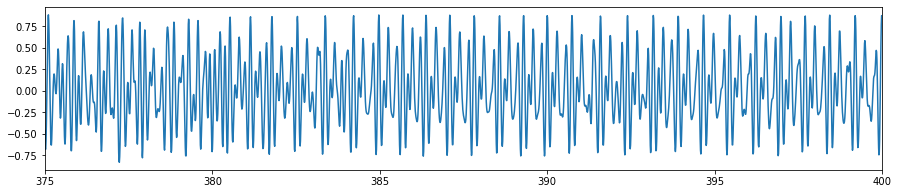

In [422]:
plt.figure(figsize=(15,3))
plt.plot(d["corr_times"], nk.signal_filter(d["corrs"], highcut=10, sampling_rate=d["new_sampling_rate"]))
plt.xlim(xlim_td)
plt.show()

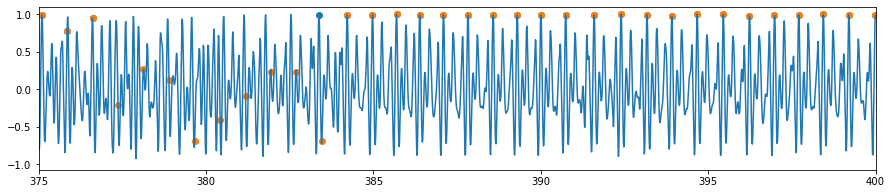

In [423]:
plt.figure(figsize=(15,3))
plt.plot(d["corr_times"], d["corrs"])
plt.scatter(d["new_peak_time"], d["corrs"][timestamp_to_samp(d["new_peak_time"], sig_time=d["corr_times"])])
plt.scatter(d["final_peak_time"], d["corrs"][timestamp_to_samp(d["final_peak_time"], sig_time=d["corr_times"])])

plt.xlim(xlim_td)
plt.show()

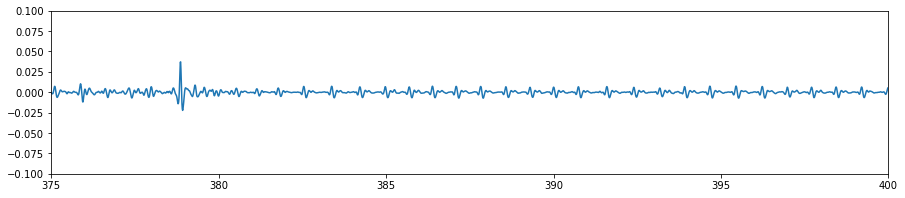

In [424]:
plt.figure(figsize=(15,3))
plt.plot(d["clean_sig_time_r"], d["clean_sig_r"])
plt.ylim([-0.1, 0.1])
plt.xlim(xlim_td)
plt.show()

In [425]:
#find_files_with_string(string="pantompkins1985", file_dir=code_paths["repo_path"])

In [426]:
# things to experiment with
# changing highcut [20, 30]
# changing k_nearest_intervals [8, 12, 14]
# changing interpolation method to something more complex than linear, e.g. polynomial with order=3 (probably need to unpack dict for this **interpolation_args)
# or just argument with string
# can also try changing fixpeaks by height to be only the times that were changed
# can change size of HB template too...
# rri_anomalies thresholds
# threshold for peak fixing
# clean_method in fixpeaks_by_height
# time_boundaries in fixpeaks_by_height
# or just give option to pass clean_sig_info and raw_sig_info
# can adapt the time_boundaries in fix_peaks_by_height based on the heart rate variability of confident intervals
# or more outlier removal

In [427]:
all_sub_part_ids = P5_StressDataLoader().get_all_sub_part_ids()
version_id = 1000
data_format = "DB8k"
# sig_name = "zephyr_ecg"
sig_name = "ieml"
# hb_extract_method = "critias_bp"

# frame_len = 30
# frame_len = 180
# frame_len = 180
ecg_process_methods = [
    "neurokit",
    "pantompkins1985",
    "hamilton2002",
    "christov2004",
    "engzeemod2012",
    "elgendi2010",
    "kalidas2017",
]
hb_extract_method = "pc"
hb_extract_method = "nk_ppg_elgendi"
hb_extract_method = "temp"
repo = git.Repo(search_parent_directories=True)
git_hexsha = repo.head.object.hexsha

# for frame_len in [15, 30, 60, 90, 120, 150, 300, 600, 900]:
# for frame_len in [75, 100]:
# for frame_len in [180, 600]:
time_boundaries1 = {}
time_boundaries1["before_peak_clean"] = 0.1
time_boundaries1["after_peak_clean"] = 0.1
time_boundaries1["before_peak_raw"] = 0.005
time_boundaries1["after_peak_raw"] = 0.005

time_boundaries2 = {}
time_boundaries2["before_peak_clean"] = 0.25
time_boundaries2["after_peak_clean"] = 0.25
time_boundaries2["before_peak_raw"] = 0.005
time_boundaries2["after_peak_raw"] = 0.005
fixpeaks_by_height_time_boundaries = time_boundaries1
fix_interpl_peaks_by_height = False
fix_corr_peaks_by_height = False
k_nearest_intervals = 8
frame_len = 300
fix_added_interpl_peaks_by_height = False
interpolate_args = {"method": "linear"}

version_id += 1
sub_id = "P02"
part_id = 1
loader = P5_StressDataLoader(sub_id=sub_id, part_id=part_id)
sig_info = loader.get_sig(data_format=data_format, sig_name=sig_name)

if "nk" in hb_extract_method:
    auto_method_acronym = "NK"
else:
    auto_method_acronym = hb_extract_method.upper()
name_peaks_dict = {"zephyr_ecg": "R_Peak", "ti_ppg": "SP", "ieml": "S1_Peak"}
label = name_peaks_dict[sig_info["name"]]


txt_json_base_name = (
    "P5_Stress-"
    + loader.sub_label
    + "_"
    + str(loader.part_id)
    + "-"
    + get_camel_case(sig_info["name"], first_upper=True)
    + "-Ann-Auto-"
    + auto_method_acronym
    + "-"
    + name_peaks_dict[sig_info["name"]]
    + "_v"
    + str(version_id)
)
txt_file_name = txt_json_base_name + ".txt"
json_file_name = txt_json_base_name + ".json"
txt_path = str(
    pathlib.Path(
        loader.get_paths(data_format="hb_annotations")["sub_data_dir"],
        "v" + str(version_id),
        txt_file_name,
    )
)

json_path = str(
    pathlib.Path(
        loader.get_paths(data_format="hb_annotations")["sub_data_dir"],
        "v" + str(version_id),
        json_file_name,
    )
)

debug_out_path = str(
    pathlib.Path(
        loader.get_paths(data_format="hb_annotations")["sub_data_dir"],
        "v" + str(version_id),
        txt_json_base_name + "_debug_out",
    )
)

hb_extract_algo_kwargs = {
    "max_bpm": 200,
    "min_bpm": 40,
    "denoiser_type": "null",
    "thr_corr_height": -3,
    "min_n_confident_peaks": 20,
    "max_time_after_last_peak": 5,
    "clean_method": "own_filt",
    "highcut": 25,
    "fix_corr_peaks_by_height": fix_corr_peaks_by_height,
    "fix_interpl_peaks_by_height": fix_interpl_peaks_by_height,
    "fix_added_interpl_peaks_by_height": fix_added_interpl_peaks_by_height,
    "corr_peak_extraction_method":"nk_ecg_process",
    "k_nearest_intervals": k_nearest_intervals,
    "n_nan_estimation_method":"round",
    "interpolate_args": interpolate_args,
    "fixpeaks_by_height_time_boundaries": fixpeaks_by_height_time_boundaries,
    "output_format":"debug_out",
    "debug_out_path":debug_out_path
}

hb_extract_params = hb_extract_algo_kwargs.copy()
hb_extract_params["detector_type"] = hb_extract_method
hb_extract_params["frame_len"] = frame_len
hb_extract_params["validity"] = True
hb_extract_params["version"] = version_id
hb_extract_params["git_hexsha"] = git_hexsha

write_dict_to_json(hb_extract_params, json_path=json_path)


if not pathlib.Path(txt_path).is_file():
    sig_info["peak_time"] = frame_timestamps(
        func=hb_extract,
        sig=sig_info["sig"],
        sig_time=sig_info["time"],
        frame_len=frame_len,
        sig_name=sig_info["name"],
        method=hb_extract_method,
        hb_extract_algo_kwargs=hb_extract_algo_kwargs,
        save_file=True,
        txt_path=txt_path,
        label=label,
    )

KeyboardInterrupt: 

In [ ]:
np.append(np.array([1, 2, 3]), 3)

In [6]:
sig_info["peak_time"] = frame_timestamps(
    func=hb_extract,
    sig=sig_info["sig"],
    sig_time=sig_info["time"],
    frame_len=frame_len,
    sig_name=sig_info["name"],
    save_file=True,
    txt_path=txt_path,
    label=label,
)

In [11]:
all_sub_part_ids = P5_StressDataLoader().get_all_sub_part_ids()
for sub_id, part_id in all_sub_part_ids:

In [12]:
sig_info["peak_time"] = frame_timestamps(
    func=hb_extract,
    sig=sig_info["sig"],
    sig_time=sig_info["time"],
    frame_len=frame_len,
    sig_name=sig_info["name"],
    save_file=True,
    txt_path=txt_path,
    label=label,
)

In [6]:
timestamps_to_audacity_txt

<function stresspred.preprocessing.timestamps_to_audacity_txt(timestamp, txt_path='out.txt', label='timestamp', save=True, rewrite=False)>

In [ ]:
# part_id = 2
part_id = 1
# for sub_id in [4]:
sig_names = ["zephyr_ecg", "ti_ppg", "ieml"]
sig_names = ["zephyr_ecg", "ti_ppg"]
sig_names = ["ieml"]
for sub_id in [5]:
    for sig_name in sig_names:
        data_format = "DB8k"
        loader = P5_StressDataLoader(sub_id=sub_id, part_id=part_id)
        sig_info = loader.get_sig(data_format=data_format, sig_name=sig_name)
        data_format_paths = loader.get_paths(data_format=data_format)
        df_for_class = loader.get_timestamps_df_for_class()
        timestamps_to_audacity_txt(
            df_for_class.loc[:, ["start_time", "end_time"]].values,
            #str(data_format_paths["zephyr_ecg_sig"].stem) + "_task" + ".txt",
            ("P5_Stress-"
            + loader.sub_label
            + "_"
            + str(loader.part_id)
            + "-"
            + get_camel_case(sig_info["name"], first_upper=True)
            + "-Ann-Manual-LT-Task.txt"),
            label="to_label",
            rewrite=True
        )
        sig_info["peak_time"] = hb_extract(sig=sig_info["sig"], sig_time=sig_info["time"], sig_name=sig_info["name"])
        name_peaks_dict = {"zephyr_ecg": "R_Peak", "ti_ppg": "SP", "ieml": "S1_Peak"}
        if sig_name == "ieml":
            auto_method_acronym = "PC"
        else:
            auto_method_acronym = "NK"
        timestamps_to_audacity_txt(
            sig_info["peak_time"],
            # str(data_format_paths[sig_info["name"] + "_sig"].stem) + "_peaks_auto" + ".txt",
            "P5_Stress-"
            + loader.sub_label
            + "_"
            + str(loader.part_id)
            + "-"
            + get_camel_case(sig_info["name"], first_upper=True)
            + "-Ann-Auto-"
            + auto_method_acronym
            + "-"
            + name_peaks_dict[sig_info["name"]]
            + ".txt",
            label=name_peaks_dict[sig_info["name"]],
            rewrite=True
        )

In [4]:
# part_id = 2
part_id = 1
# for sub_id in [4]:
sig_names = ["zephyr_ecg", "ti_ppg", "ieml"]
sig_names = ["ieml"]
sig_names = ["zephyr_ecg", "ti_ppg"]
for sub_id in [5]:
    for sig_name in sig_names:
        data_format = "DB8k"
        loader = P5_StressDataLoader(sub_id=sub_id, part_id=part_id)
        sig_info = loader.get_sig(data_format=data_format, sig_name=sig_name)
        data_format_paths = loader.get_paths(data_format=data_format)
        df_for_class = loader.get_timestamps_df_for_class()
        timestamps_to_audacity_txt(
            df_for_class.loc[:, ["start_time", "end_time"]].values,
            #str(data_format_paths["zephyr_ecg_sig"].stem) + "_task" + ".txt",
            ("P5_Stress-"
            + loader.sub_label
            + "_"
            + str(loader.part_id)
            + "-"
            + get_camel_case(sig_info["name"], first_upper=True)
            + "-Ann-Manual-LT-Task.txt"),
            label="to_label",
            rewrite=True
        )
        sig_info["peak_time"] = hb_extract(sig=sig_info["sig"], sig_time=sig_info["time"], sig_name=sig_info["name"])
        name_peaks_dict = {"zephyr_ecg": "R_Peak", "ti_ppg": "SP", "ieml": "S1_Peak"}
        timestamps_to_audacity_txt(
            sig_info["peak_time"],
            # str(data_format_paths[sig_info["name"] + "_sig"].stem) + "_peaks_auto" + ".txt",
            "P5_Stress-"
            + loader.sub_label
            + "_"
            + str(loader.part_id)
            + "-"
            + get_camel_case(sig_info["name"], first_upper=True)
            + "-Ann-Auto-NK-"
            + name_peaks_dict[sig_info["name"]]
            + ".txt",
            label=name_peaks_dict[sig_info["name"]],
            rewrite=True
        )

{'label': ['rest_task_mentalNoise', 'rest_task_mental', 'rest_task_cpt', 'rest_task_speechBaseline', 'rest_task_speechStressed', 'task_mentalNoise', 'task_mental', 'task_cpt', 'task_speechBaseline', 'task_speechStressed'], 'start_time': array([ 215.84375925,  873.25803475, 1537.942431  , 2206.231749  ,
       2879.155857  ,  508.9490462 , 1176.175937  , 1834.999488  ,
       2525.009788  , 3170.219649  ]), 'end_time': array([ 395.84375925, 1053.25803475, 1717.942431  , 2386.231749  ,
       3059.155857  ,  688.9490462 , 1356.175937  , 2014.999488  ,
       2705.009788  , 3350.219649  ])}
{'label': ['rest_task_mentalNoise', 'rest_task_mental', 'rest_task_cpt', 'rest_task_speechBaseline', 'rest_task_speechStressed', 'task_mentalNoise', 'task_mental', 'task_cpt', 'task_speechBaseline', 'task_speechStressed'], 'start_time': array([ 215.84375925,  873.25803475, 1537.942431  , 2206.231749  ,
       2879.155857  ,  508.9490462 , 1176.175937  , 1834.999488  ,
       2525.009788  , 3170.219649 

In [5]:
sig_info["peak_time"]

array([8.71891149e-01, 1.32683435e+00, 2.07174135e+00, ...,
       3.55360135e+03, 3.55471021e+03, 3.55554211e+03])

In [8]:
type(hb_extract)

NoneType

In [ ]:
timestamps_to_audacity_txt

In [ ]:
"""
sig_info["cor_peak_time"] = find_local_hb_peaks(sig_info["peak_time"], 
                     sig=sig_info["sig"], 
                     sig_time=sig_info["time"], 
                     sampling_rate=sig_info["sampling_rate"], 
                     check_height_outlier=True)
"""

In [ ]:
# should be two outputs of TEMP: peaks we are confident in, and complete interpolated peak times
# parameters I should try changing: 

In [ ]:
s = "ti_ppg"
s = re.sub(r"(_|-)+", " ", s).title().replace(" ", "")
s

In [ ]:
P5_Stress-P01-TiPpg-Ann-Manual-LT-Task

In [ ]:
P5_Stress-P01-TiPpg-Ann-Auto-NK-SP